## Sequence generations

### created by Yuying Liu, 06/10/2020

This script is a template for sequence generation with different neural network architectures, including our multiscale HiTS, LSTM, ESN and CW-RNN. We carefully choose the number of hidden units for each so that the amount of trainable parameters are close. The {model}\_pred.npy files are generated and will be further fed to other scripts for visualization.

In [1]:
# imports
import os
import sys
import torch
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as resnet
import rnn
import esn
import cwrnn

In [2]:
path_to_fluid = '../../data/Fluid/'
path_to_flower = '../../data/Flower/'
path_to_Bach = '../../data/Bach/'
path_to_KS = '../../data/KS/'

path_to_model = '../../models/'
path_to_result = '../../results/'

In [3]:
# fluid_data = np.load(os.path.join(path_to_fluid, 'data.npy'))
flower_data = np.load(os.path.join(path_to_flower, 'data.npy'))
# Bach_data = np.load(os.path.join(path_to_Bach, 'data.npy'))
# ks_data = np.load(os.path.join(path_to_KS, 'data.npy'))

# print('fluid data: ', fluid_data.shape)
print('flower data: ', flower_data.shape)
# print('Bach data: ', Bach_data.shape)
# print('KS data: ', ks_data.shape)

flower data:  (64, 175)


In [27]:
# adjustable parameters

normalize = True                   # if to normalize the features 
data = flower_data.T#fluid_data.T                # choose the sequence you want to generate
model_prefix = 'flower'#'Fluid'             # 'Fluid', 'Flower', 'KS' or 'Bach'
n_forward = 3                      # number of training steps
archs = [ [64, 128, 64], 
         [64, 64, 64], 
         [64, 32, 64]]              # multscale HiTS architecture, details can be found in table 4
step_sizes = [ 1, 4, 16]        # step sizes of HiTSs, details can be found in Appendix A.3
lr = 1e-3                          # learning rate
max_epoch = 10000                  # maximum number of epochs
batch_size = 100                   # training batch size

if normalize:
    mean_values = data.mean(0)
    ranges = data.ptp(0)
    data = (data - mean_values)/ranges

In [28]:
175/16

10.9375

### coupled NNs

In [30]:
# dummy parameter
dt = 1  

# training
models = []
n_steps = data.shape[0] - 1  # number of forward steps
for (arch, step_size) in zip(archs, step_sizes):
    m = int(np.ceil(n_steps/(step_size*n_forward)))
    pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
    for i in range(m):
        start_idx = i*step_size*n_forward
        end_idx = start_idx + step_size*n_forward + 1
        tmp = data[start_idx:end_idx, :]
        pdata[i, :tmp.shape[0], :] = tmp
        
    print(pdata.shape)
    dataset = resnet.DataSet(pdata, pdata, data[np.newaxis, :], dt, step_size, n_forward)
    print('MODEL: '+model_prefix+'_D{}'.format(step_size))
    model = resnet.ResNet(arch=arch, dt=dt, step_size=step_size)
    model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(path_to_model, model_prefix, model_prefix+'_D{}.pt'.format(step_size)))
    models.append(model)

print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

(29, 7, 64)
MODEL: flower_D1
time for first 10 =  0.12688732147216797
epoch 1000, training loss 0.0004574275517370552, validation loss 0.0004574274644255638
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.00010240768460789695, validation loss 0.00010240769188385457
(--> new model saved @ epoch 2000)
epoch 3000, training loss 6.191937427502126e-05, validation loss 6.191937427502126e-05
(--> new model saved @ epoch 3000)
epoch 4000, training loss 4.0867711504688486e-05, validation loss 4.08677187806461e-05
(--> new model saved @ epoch 4000)
epoch 5000, training loss 3.2668533094692975e-05, validation loss 3.2668522180756554e-05
(--> new model saved @ epoch 5000)
epoch 6000, training loss 2.814520848914981e-05, validation loss 2.8145210308139212e-05
(--> new model saved @ epoch 6000)
epoch 7000, training loss 0.00016180660168174654, validation loss 0.0001618065289221704
epoch 8000, training loss 2.394834518781863e-05, validation loss 2.3948352463776246e-05
(--> new model sa

In [25]:
data.shape

(175, 64)

In [31]:
models = []
for step_size in step_sizes:
    models.append(torch.load(os.path.join(path_to_model, model_prefix, model_prefix+'_D{}.pt'.format(step_size))))

y_preds = resnet.vectorized_multi_scale_forecast(dataset.test_x, n_steps=n_steps, models=models)
y_preds = torch.cat([dataset.test_x.unsqueeze(0), y_preds], dim=1).squeeze().detach().numpy()
if normalize:
    y_preds = y_preds * ranges + mean_values
# np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_couple_pred.npy', y_preds))

torch.Size([1, 174, 64])
(175, 64)


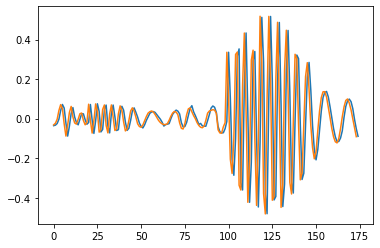

In [32]:
print(dataset.test_ys.shape)
print(y_preds.shape)

idx = 50
plt.plot(y_preds[:,idx])
plt.plot(dataset.test_ys[0,:,idx])

In [ ]:
stop

### lstm

In [ ]:
# choose the hidden size so that # of parameters match 
model = rnn.LSTMWrapper(data.shape[-1], 740)
print('# of params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch = 0
best_loss = 1e+5
while epoch < max_epoch:
    epoch += 1
    preds = model(torch.tensor(data[np.newaxis, :-1, :]).float())
    loss = criterion(preds, torch.tensor(data[np.newaxis, 1:, :]).float())
    if best_loss <= 1e-8:
        print('--> model has reached an accuracy of 1e-8! Finished training!')
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print('epoch {}, training loss {}'.format(epoch, loss.item()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print('(--> new model saved @ epoch {})'.format(epoch))
            torch.save(model, os.path.join(path_to_model, model_predix, model_prefix+'_lstm.pt'))

In [ ]:
model = torch.load(os.path.join(path_to_model, model_predix, model_prefix+'_lstm.pt'))
y_init = torch.tensor(data[np.newaxis, [0], :]).float()
y_preds = model(y_init, t=data.shape[0]-1)
y_preds = torch.cat([y_init, y_preds], dim=1).squeeze().detach().numpy()
if normalize:
    y_preds = y_preds * ranges + mean_values
np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_lstm_pred.npy', y_preds))

### reservoir computing

In [ ]:
# choose the hidden size so that # of parameters match 
model = esn.ESN(data.shape[1], 1600)
y_pred = model(torch.tensor(data[:-1, :]).float())
truth = torch.tensor(data[1:, :]).float()
W_out = y_pred.pinverse() @ truth
print('# of params: ', W_out.shape[0]*W_out.shape[1])

In [ ]:
y_preds = torch.zeros(data.shape)
y_preds[0, :] = torch.tensor(data[0, :]).float()

h_pred = model.f(model.W_in @torch.tensor(data[0, :]).float())
y_pred = torch.matmul(h_pred, W_out)
y_preds[1, :] = y_pred
for t in range(2, data.shape[0]):
    h_pred = model.f(model.W_in @ y_pred + model.W_hat @ h_pred)
    y_pred = torch.matmul(h_pred, W_out)
    y_preds[t, :] = y_pred
    
y_preds = y_preds.detach().numpy()
if normalize:
    y_preds = y_preds * ranges + mean_values
np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_reservoir_pred.npy', y_preds))

### cw-rnn

In [ ]:
# choose the hidden size so that # of parameters match 
model = cwrnn.CwRNN(data.shape[-1], 1570, 5)
print('# of params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch = 0
best_loss = 1e+5
while epoch < max_epoch:
    epoch += 1
    preds = model(torch.tensor(data[np.newaxis, :-1, :]).float())
    loss = criterion(preds, torch.tensor(data[np.newaxis, 1:, :]).float())
    if best_loss <= 1e-8:
        print('--> model has reached an accuracy of 1e-8! Finished training!')
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print('epoch {}, training loss {}'.format(epoch, loss.item()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print('(--> new model saved @ epoch {})'.format(epoch))
            torch.save(model, os.path.join(path_to_model, model_predix, model_prefix+'_cwrnn.pt'))

In [ ]:
model = torch.load(os.path.join(path_to_model, model_predix, model_prefix+'_cwrnn.pt'))
y_preds = model.forecast(torch.tensor(data[[0], :]).float(), data.shape[0]-1)
y_preds = torch.cat([torch.tensor(data[[0], :]).float(), y_preds.squeeze()], dim=0).detach().numpy()
if normalize:
    y_preds = y_preds * ranges + mean_values
np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_cwrnn_pred.npy', y_preds))